## **3D Semantic Segmentation of MRI scans**

In [1]:
# Libraries
import os
import numpy as np
#import nibabel as nib ## Uncomment for preprocessing
import glob
import random
#from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
#import tensorflow as tf

In [2]:
# Define the scaler function (MinMax)
scaler = MinMaxScaler()

In [3]:
# Set base path for training data
base_path = "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
base_path_test = "BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"

# Open the all the channels for a traning image (flair channel)
test_image_flair = nib.load(base_path + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
test_image_t1=nib.load(base_path + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1ce=nib.load(base_path + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t2=nib.load(base_path + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_mask=nib.load(base_path + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
# As we can see the image is a 3D image with 240x240x155
print(f"Dimensions of the (flair) image: {test_image_flair.shape}")
print(f"Max value in the (flair) array: {test_image_flair.max()}")

Dimensions of the (flair) image: (240, 240, 155)
Max value in the (flair) array: 1854.603271484375


### **Preprocessing**

In [4]:
# Applying the scaler to 1D and then reshape back into 3D
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# Check the values in the mask file
test_mask=test_mask.astype(np.uint8)
print(np.unique(test_mask))

[0 1 2 4]


In [5]:
# Since the third class isnt defined, make class 4 into class 3
test_mask[test_mask==4] = 3
print(np.unique(test_mask))

[0 1 2 3]


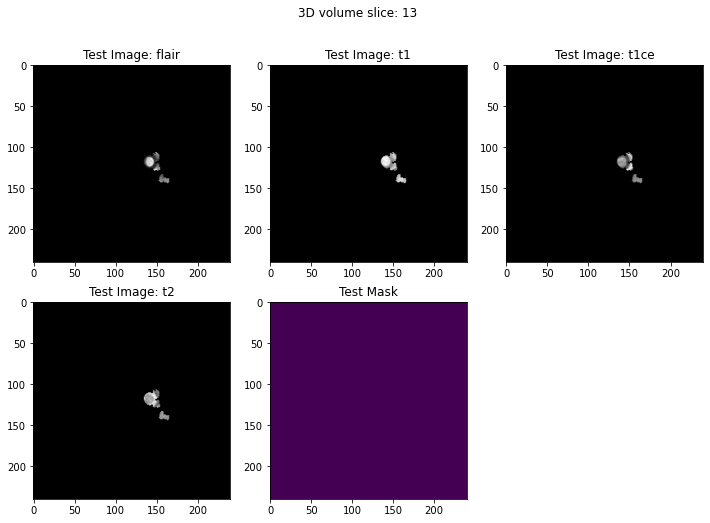

In [6]:
# Since the data is 3D we can only look at slices of the image (155) slices as a 2D image.

# Select a random slice

n_slice = random.randint(0, test_mask.shape[2])

# Print the images
plt.figure(figsize = (12,8))
plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Test Image: flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Test Image: t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Test Image: t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Test Image: t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Test Mask')
plt.suptitle(f"3D volume slice: {n_slice}")
plt.show()

In [7]:
# Since t1ce is a transformation of t1, we can drop the t1 (as it only contains less information)

# Therefore we combine the flair, t1ce and t2 channels into a single array
combined_volume = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis = 3)
combined_volume.shape

(240, 240, 155, 3)

In [8]:
# Crop the image to 128x128x128x4 centered around the main information 
# the sides of the images doesnt contain any information and can be dropped. 
# The size has to be a multiple of 16

combined_volume = combined_volume[56:184, 56:184, 13:141]
test_mask = test_mask[56:184, 56:184, 13:141]

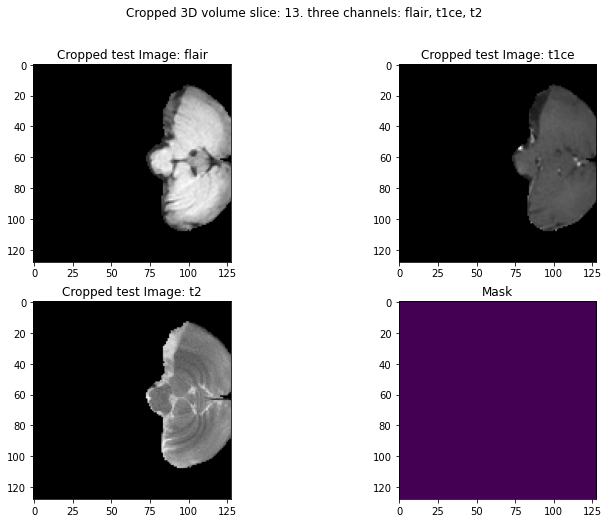

In [9]:
# Print the cropped images

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(combined_volume[:,:,n_slice, 0], cmap='gray')
plt.title('Cropped test Image: flair')
plt.subplot(222)
plt.imshow(combined_volume[:,:,n_slice, 1], cmap='gray')
plt.title('Cropped test Image: t1ce')
plt.subplot(223)
plt.imshow(combined_volume[:,:,n_slice, 2], cmap='gray')
plt.title('Cropped test Image: t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.suptitle(f"Cropped 3D volume slice: {n_slice}. three channels: flair, t1ce, t2")
plt.show()

In [10]:
# Save the images as a numpy array and see if we can read it properly
np.save("BraTS2020_TrainingData/combined255.npy", combined_volume)
my_img = np.load("BraTS2020_TrainingData/combined255.npy")
print(f"Saved array has dimensions: {my_img.shape}")
print(f"Saved array and and processed array are equal: {np.array_equal(my_img, combined_volume)}")

Saved array has dimensions: (128, 128, 128, 3)
Saved array and and processed array are equal: True


In [11]:
# Make categorical mask
test_mask = to_categorical(test_mask, num_classes = 4)

In [12]:
t2_list = sorted(glob.glob(base_path + "*/*t2.nii"))
t1ce_list = sorted(glob.glob(base_path + "*/*t1ce.nii"))
flair_list = sorted(glob.glob(base_path + "*/*flair.nii"))
mask_list = sorted(glob.glob(base_path + "*/*seg.nii"))

# Test data doesn't have any masks
t2_list_test = sorted(glob.glob(base_path_test + "*/*t2.nii"))
t1ce_list_test = sorted(glob.glob(base_path_test + "*/*t1ce.nii"))
flair_list_test = sorted(glob.glob(base_path_test + "*/*flair.nii"))
#mask_list_val = sorted(glob.glob(base_path_val + "*/*seg.nii"))

print(f"The training lists have equal length: {len(t2_list) == len(t1ce_list) == len(flair_list) == len(mask_list)}, length is {len(t2_list)}")
print(f"The test lists have equal length: {len(t2_list_test) == len(t1ce_list_test) == len(flair_list_test)}, length is {len(t2_list_test)}")

The training lists have equal length: True, length is 369
The test lists have equal length: True, length is 125


In [13]:
# Lets create the folders we need

top_directory = "data_dir/"
os.mkdir(top_directory)

directory = "input_data_3channels"

path = os.path.join(top_directory, directory)
os.mkdir(path)

directory_train = top_directory + directory + "/"
directory_img = "images"
train_img_path = os.path.join(directory_train, directory_img)
os.mkdir(train_img_path)

directory_mask = "masks"
train_mask_path = os.path.join(directory_train, directory_mask)
os.mkdir(train_mask_path)

test_directory = "test/"
path = os.path.join(top_directory, test_directory)
os.mkdir(path)

test_img_path = os.path.join(top_directory, test_directory+directory_img)
os.mkdir(test_img_path)

In [14]:
# Load, MinMax scale, combine and crop all training images then save
for img in range(len(t2_list)):
    #print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        #print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save(train_img_path + '/image_' +str(img) + '.npy', temp_combined_images)
        np.save(train_mask_path + '/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("Image with less than 0.01 % of relevant information")   
    

Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with l

In [15]:
# Load, MinMax scale, combine and crop all test images (which we will use for testing) then save
for img in range(len(t2_list_test)):
    #print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list_test[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list_test[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list_test[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
       
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]

    np.save(test_img_path + '/testimage_' + str(img) + '.npy', temp_combined_images)

In [19]:
#pip install split-folders

# START HERE

In [16]:
import splitfolders
input_folder = 'data_dir/input_data_3channels/'
output_folder = 'data_dir/trainval/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

In [ ]:
# Optional: Delete some of the unpreprocessed data to clean up space





### **Using the custom data generator**

In [2]:
# Import the custom script
import custom_datagenerator as datagen

In [3]:
# define our data paths
train_img_path = "data_dir/trainval/train/images"
train_mask_path = "data_dir/trainval/train/masks"

val_img_path = "data_dir/trainval/val/images"
val_mask_path = "data_dir/trainval/val/masks"

print(train_img_path)
print(train_mask_path)
print(val_img_path)
print(val_mask_path)

data_dir/trainval/train/images
data_dir/trainval/train/masks
data_dir/trainval/val/images
data_dir/trainval/val/masks


In [4]:
# Get a list of the images and masks
train_img_list = sorted(os.listdir(train_img_path))
train_mask_list = sorted(os.listdir(train_mask_path))

val_img_list = sorted(os.listdir(val_img_path))
val_mask_list = sorted(os.listdir(val_mask_path))

In [5]:
# Check if the sorting made them match up
print(train_img_list[0:5])
print(train_mask_list[0:5])

num_images = len(os.listdir(train_img_path))
print(f"\nNumber of training images: {num_images}")

['image_0.npy', 'image_1.npy', 'image_10.npy', 'image_101.npy', 'image_102.npy']
['mask_0.npy', 'mask_1.npy', 'mask_10.npy', 'mask_101.npy', 'mask_102.npy']

Number of training images: 258


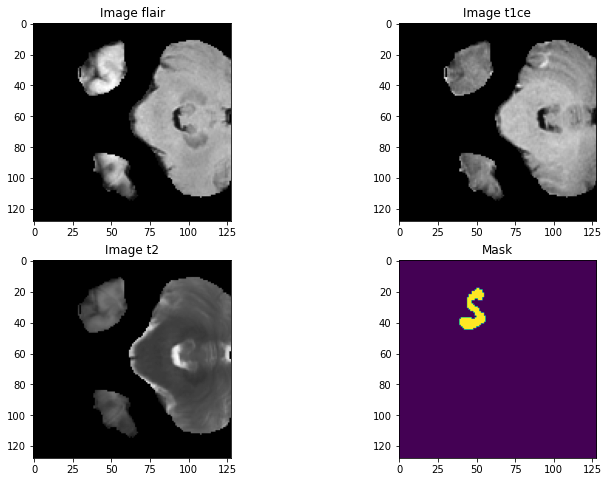

In [6]:
# A last check if the images makes sense
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_path + "/" + train_img_list[img_num])
test_mask = np.load(train_mask_path + "/" +train_mask_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [7]:
import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list_temp = sorted(glob.glob('data_dir/trainval/train/masks/*.npy'))
for img in range(len(train_mask_list_temp)):
    #print(img)
    temp_image=np.load(train_mask_list_temp[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

print(f"Weight of label 0: {wt0}")
print(f"Weight of label 0: {wt1}")
print(f"Weight of label 0: {wt2}")
print(f"Weight of label 0: {wt3}")

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss 

Weight of label 0: 0.26
Weight of label 0: 22.53
Weight of label 0: 22.53
Weight of label 0: 26.21


In [8]:
wt0 = 0.26
wt1 = 22.53
wt2 = 22.53
wt3 = 26.21

In [9]:
# Make the generator avaiable
batch_size = 2

train_img_datagen = datagen.imageLoader(train_img_path, train_img_list, train_mask_path, train_mask_list,
                                       batch_size)

val_img_datagen = datagen.imageLoader(val_img_path, val_img_list, val_mask_path, val_mask_list,
                                       batch_size)

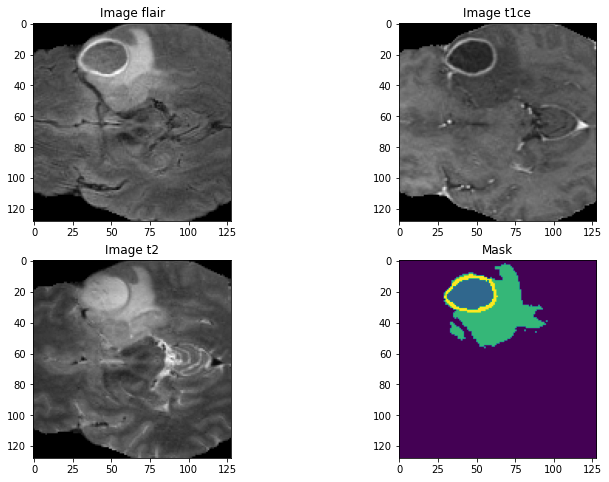

In [10]:
# Check that the generator works properly
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

### **Training the model**

In [2]:
import tensorflow as tf
import losses as ls


In [ ]:
dice_loss = ls.dice_coef_loss()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/theo/anaconda3/envs/braintumor_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_25371/371101226.py", line 1, in <module>
    dice_loss = ls.dice_coef_loss()
TypeError: dice_coef_loss() missing 2 required positional arguments: 'y_true' and 'y_pred'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/theo/anaconda3/envs/braintumor_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/theo/anaconda3/envs/braintumor_env/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_reco

In [14]:
# Define the loss, metrics and optimizer

# We defined the weights above

#dice_loss = custom_losses.DiceLoss(class_weights = np.array([wt0, wt1, wt2, wt3]))
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1*focal_loss)

#metrics = ["accuracy", sm.metrics.IOUScore(threshold = 0.5)]

#lr = 0.0001
#optim = keras.optimizers.Adam(lr)

ERROR! Session/line number was not unique in database. History logging moved to new session 955


In [15]:
#conda install cudatoolkit=11.0.

Solving environment: done

## Package Plan ##

  environment location: /home/theo/anaconda3/envs/braintumor3_env

  added / updated specs:
    - cudatoolkit=11.0


The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2020.10.14-0 --> pkgs/main::ca-certificates-2022.3.29-h06a4308_0
  certifi                anaconda::certifi-2020.6.20-py37_0 --> pkgs/main::certifi-2021.10.8-py37h06a4308_2


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
